In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from xgboost import XGBRegressor
import joblib

2024-06-16 16:44:26.089941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 16:44:26.209294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/apps/22.04/openmpi/4.1.5/lib:/share/apps/22.04/slurm/23.02.7/lib
2024-06-16 16:44:26.209330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-16 16:44:26.244923: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [56]:
def generate_stand_age_predictions(group, model, var,grid, group_label):
    # 1. Create the stand_ages DataFrame
    stand_ages = pd.DataFrame({'ordinal_stand_age': np.arange(23)})
    stand_ages['dummy_key'] = 1
    
    # 2. Filter the input data for the specified years (group)
    group_input = input_data[input_data['year'].isin(group)].copy()
    
    # 3. Merge the filtered input data with the grid data
    group_input = pd.merge(group_input, grid, on=['lon', 'lat'], how='inner')
    
    # 4. Add a dummy key to the filtered input data
    group_input['dummy_key'] = 1
    
    # 5. Perform the cross join with the stand_ages DataFrame and remove the dummy key
    group_input = pd.merge(group_input, stand_ages, on='dummy_key').drop(columns=['dummy_key'])
    
    # 6. Predict using the specified model
    group_input[var] = model.predict(group_input[pred_vars])

    # 7. Print the summary of the predictions
    print(group_input[var].describe())
    
    # 8. Replace negative predictions with 0 and cap at 30000
    # group_input[var] = group_input[var].clip(lower=0, upper=30000)
    
    # 9. Calculate the mean predictions by ordinal_stand_age
    group_sa = group_input.groupby('ordinal_stand_age')[var].mean().reset_index(name=f'mean_{var}')
    
    # 10. Add the label column with the group label
    group_sa['label'] = group_label
    
    # 11. Return the result
    return group_sa

In [53]:
pred_vars = ['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']


In [ ]:
# Loading data

# base_comparison = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/global_input_vars.csv')
input_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/whole_time_CanESM5xx1_ssp245_global_input_vars.csv')


In [11]:
annual_avg

,year,tair_avg,prec_avg,compare_tair,compare_prec,tair_delta,prec_ratio,temp_degree,prec_change
0,2021,10.846651,92.066708,11.92,62.41,-1.073349,0.475192,-2,48
1,2022,10.835299,95.517076,11.92,62.41,-1.084701,0.530477,-2,53
2,2023,11.117568,96.481453,11.92,62.41,-0.802432,0.545929,-1,55
3,2024,11.211395,93.824251,11.92,62.41,-0.708605,0.503353,-1,50
4,2025,11.317837,90.721630,11.92,62.41,-0.602163,0.453639,-1,45
...,...,...,...,...,...,...,...,...,...
75,2096,13.867236,103.514480,11.92,62.41,1.947236,0.658620,1,66
76,2097,13.992409,101.602891,11.92,62.41,2.072409,0.627991,2,63
77,2098,14.106868,105.064350,11.92,62.41,2.186868,0.683454,2,68
78,2099,14.069916,100.156667,11.92,62.41,2.149916,0.604818,2,60


In [12]:
base_comparison

,lon,lat,year,tswrf_v11_avg,tswrf_v11_min,tswrf_v11_max,tmp_avg,tmp_min,tmp_max,precip_avg,...,Area,s1,s2,s3,tt,soil_text,region,var_y,elev,co2
0,-177.0,-44.0,1700,172.03,60.34,283.01,11.92,6.3,17.5,62.41,...,991,28.79,27.98,43.23,0,IGBP,AUSTRAL,ELEV,90.0,276.59
1,-176.5,-44.0,1700,172.08,61.24,280.29,11.94,6.4,17.5,72.34,...,743,28.79,27.98,43.23,0,IGBP,AUSTRAL,ELEV,90.0,276.59
2,-175.5,-21.5,1700,221.42,155.31,290.48,24.18,21.9,26.6,133.50,...,758,86.00,7.00,7.00,0,MBL,ASIA,ELEV,0.0,276.59
3,-166.5,64.5,1700,104.08,1.54,239.98,-4.67,-17.9,9.2,29.97,...,1174,37.31,31.71,31.02,0,IGBP,NAMERICA,ELEV,162.2,276.59
4,-166.0,64.5,1700,107.84,1.83,250.71,-4.93,-18.0,9.0,28.94,...,1318,50.08,25.84,24.10,0,IGBP,NAMERICA,ELEV,245.4,276.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9854161,179.0,-18.5,2021,215.83,135.85,265.31,24.28,21.8,26.2,210.82,...,98,39.91,27.80,32.34,0,IGBP,ASIA,ELEV,335.0,414.27
9854162,179.0,-17.0,2021,245.46,180.51,300.44,25.52,23.6,26.9,233.84,...,1924,38.39,27.28,34.36,0,IGBP,ASIA,ELEV,293.5,414.27
9854163,179.0,-16.5,2021,248.61,183.86,301.19,25.96,24.0,27.4,226.65,...,1318,35.75,25.51,38.79,0,IGBP,ASIA,ELEV,180.0,414.27
9854164,179.5,-17.0,2021,243.14,178.95,295.57,25.55,23.5,26.9,223.22,...,1704,40.26,28.64,31.13,0,IGBP,ASIA,ELEV,329.0,414.27


In [26]:
base = input_data[input_data['year'].between(1950, 2000)][['tair_avg', 'prec_avg']].mean().reset_index()
base

,index,0
0,tair_avg,9.377962
1,prec_avg,89.345219


In [40]:


# Calculate annual averages
annual_avg = input_data[input_data['year'] >= 1950].groupby('year')[['tair_avg', 'prec_avg']].mean().reset_index()
annual_avg

,year,tair_avg,prec_avg
0,1950,8.961091,90.982364
1,1951,9.220548,89.164535
2,1952,9.103923,89.164965
3,1953,9.651825,89.699975
4,1954,9.190261,91.570438
...,...,...,...
146,2096,13.867236,103.514480
147,2097,13.992409,101.602891
148,2098,14.106868,105.064350
149,2099,14.069916,100.156667


In [31]:
float( base.loc[base['index'] == 'tair_avg', 0])

9.377962175949685

In [41]:
annual_avg['compare_tair'] = float(base.loc[base['index'] == 'tair_avg', 0])
annual_avg['compare_prec'] = float(base.loc[base['index'] == 'prec_avg', 0])
annual_avg['tair_delta'] = annual_avg['tair_avg'] - annual_avg['compare_tair']
annual_avg['prec_ratio'] = annual_avg['prec_avg'] / annual_avg['compare_prec'] - 1
annual_avg['temp_degree'] = np.floor(annual_avg['tair_delta']).astype(int)
annual_avg['prec_change'] = (100 * annual_avg['prec_ratio']).round().astype(int)
annual_avg


,year,tair_avg,prec_avg,compare_tair,compare_prec,tair_delta,prec_ratio,temp_degree,prec_change
0,1950,8.961091,90.982364,9.377962,89.345219,-0.416871,0.018324,-1,2
1,1951,9.220548,89.164535,9.377962,89.345219,-0.157415,-0.002022,-1,0
2,1952,9.103923,89.164965,9.377962,89.345219,-0.274039,-0.002018,-1,0
3,1953,9.651825,89.699975,9.377962,89.345219,0.273863,0.003971,0,0
4,1954,9.190261,91.570438,9.377962,89.345219,-0.187701,0.024906,-1,2
...,...,...,...,...,...,...,...,...,...
146,2096,13.867236,103.514480,9.377962,89.345219,4.489273,0.158590,4,16
147,2097,13.992409,101.602891,9.377962,89.345219,4.614447,0.137194,4,14
148,2098,14.106868,105.064350,9.377962,89.345219,4.728906,0.175937,4,18
149,2099,14.069916,100.156667,9.377962,89.345219,4.691954,0.121008,4,12


In [36]:
annual_avg['prec_change'].min()

-1

In [42]:
# Define groups
control = annual_avg[(annual_avg['temp_degree'] == 0) & (annual_avg['prec_change'] < 5)]['year']
plus1 = annual_avg[annual_avg['temp_degree'] == 1]['year']
plus2 = annual_avg[annual_avg['temp_degree'] == 2]['year']
plus3 = annual_avg[annual_avg['temp_degree'] == 3]['year']
plus4 = annual_avg[annual_avg['temp_degree'] == 3]['year']
prec6_10 = annual_avg[annual_avg['prec_change'].between(6, 10)]['year']
prec11_15 = annual_avg[annual_avg['prec_change'].between(11, 15)]['year']
prec16_20 = annual_avg[annual_avg['prec_change'].between(16, 20)]['year']
 

In [44]:
plus1

65    2015
66    2016
67    2017
68    2018
69    2019
70    2020
71    2021
72    2022
73    2023
74    2024
75    2025
76    2026
77    2027
78    2028
82    2032
83    2033
Name: year, dtype: int64

In [45]:
pfts = ["Tropical", "Temperate_Broadleaf","Temperate_Deciduous"
        ,"Temperate_Coniferous","Boreal"]

var_list = ['GPP', 'NPP', 'VEGC', 'SOILORGC']


In [82]:
pft = pfts[4]
# var = var_list[0]

In [83]:
all_model_grid = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245.csv')
all_model_grid = all_model_grid[['lon', 'lat']].drop_duplicates()

In [84]:
# generate_stand_age_predictions(control, xgb_model,var, all_model_grid, 'control')
all_standage_avgs = pd.DataFrame()   

for var in var_list:
    model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    xgb_model = joblib.load(model_filename)

    standage_avgs = pd.concat([
    generate_stand_age_predictions(control, xgb_model,var, all_model_grid, 'control'),
        generate_stand_age_predictions(plus1, xgb_model,var, all_model_grid, 'plus1'),
        generate_stand_age_predictions(plus2, xgb_model,var, all_model_grid, 'plus2'),
        generate_stand_age_predictions(plus3, xgb_model,var, all_model_grid, 'plus3'),
        generate_stand_age_predictions(plus4, xgb_model,var, all_model_grid, 'plus4'),
        generate_stand_age_predictions(prec6_10, xgb_model,var, all_model_grid, 'prec6_10'),
        generate_stand_age_predictions(prec11_15, xgb_model,var, all_model_grid, 'prec11_15'),
        generate_stand_age_predictions(prec16_20, xgb_model,var, all_model_grid, 'prec16_20')

    ], ignore_index=True)
    standage_avgs['var'] = var
    all_standage_avgs = pd.concat([all_standage_avgs, standage_avgs])

    print(var)

count    5.108760e+06
mean     4.694584e+01
std      2.086191e+01
min     -2.221927e+01
25%      3.419128e+01
50%      4.915860e+01
75%      6.112010e+01
max      1.520655e+02
Name: GPP, dtype: float64
count    2.270560e+06
mean     5.071011e+01
std      2.072833e+01
min     -1.997463e+01
25%      3.893073e+01
50%      5.322337e+01
75%      6.433418e+01
max      1.534989e+02
Name: GPP, dtype: float64
count    2.980110e+06
mean     5.285073e+01
std      2.075341e+01
min     -2.270769e+01
25%      4.125382e+01
50%      5.532994e+01
75%      6.632329e+01
max      1.532473e+02
Name: GPP, dtype: float64
count    2.554380e+06
mean     5.484300e+01
std      2.106233e+01
min     -2.027324e+01
25%      4.277501e+01
50%      5.722257e+01
75%      6.845874e+01
max      1.526601e+02
Name: GPP, dtype: float64
count    2.554380e+06
mean     5.484300e+01
std      2.106233e+01
min     -2.027324e+01
25%      4.277501e+01
50%      5.722257e+01
75%      6.845874e+01
max      1.526601e+02
Name: GPP, dtype

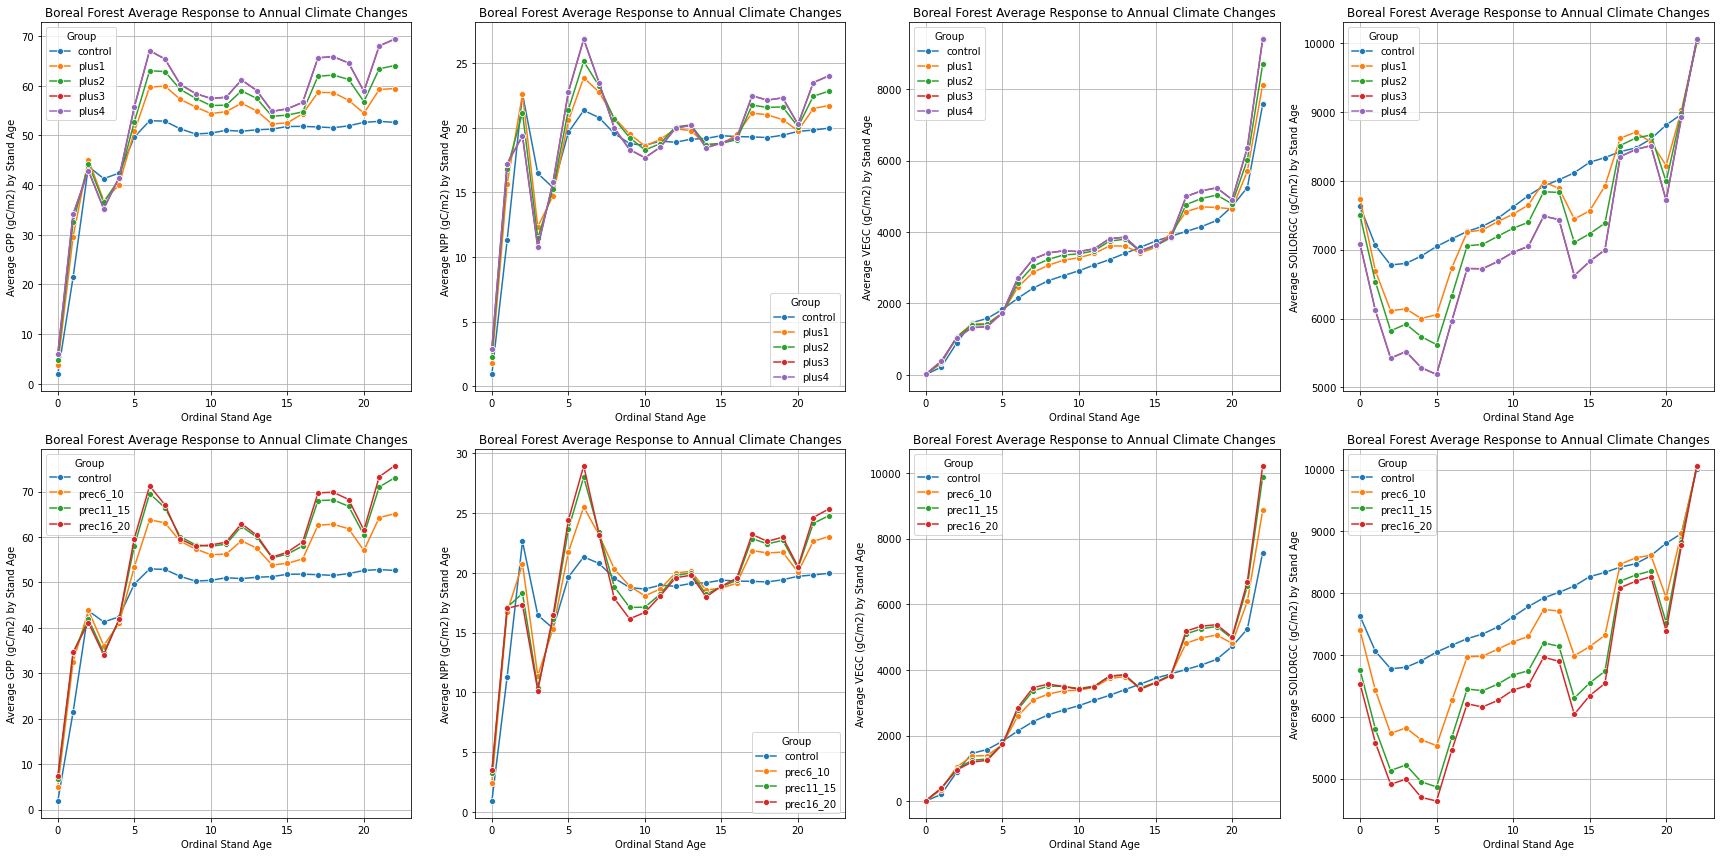

In [85]:
# Determining the number of columns and rows for the subplots
nrows = 2
ncols = len(var_list)

# Create figure and axes
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 12))

# Loop over the variables for creating the plots
for i, var in enumerate(var_list):
    # For the first row (excluding 'prec' in the label)
    sns.lineplot(
        ax=axs[0, i],
        data=all_standage_avgs.loc[
            (~all_standage_avgs['label'].str.contains('prec'))
        &(all_standage_avgs['var']==var)
        ],
        x='ordinal_stand_age', y=f'mean_{var}', hue='label', marker='o'
    )
    axs[0, i].set_title(f"{pft} Forest Average Response to Annual Climate Changes")
    axs[0, i].set_xlabel("Ordinal Stand Age")
    axs[0, i].set_ylabel(f"Average {var} (gC/m2) by Stand Age")
    axs[0, i].legend(title='Group')
    axs[0, i].grid(True)

    # For the second row (excluding 'plus' in the label)
    sns.lineplot(
        ax=axs[1, i],
        data=all_standage_avgs.loc[
            (~all_standage_avgs['label'].str.contains('plus'))
        &(all_standage_avgs['var']==var)
        ],
        x='ordinal_stand_age', y=f'mean_{var}', hue='label', marker='o'
    )
    axs[1, i].set_title(f"{pft} Forest Average Response to Annual Climate Changes")
    axs[1, i].set_xlabel("Ordinal Stand Age")
    axs[1, i].set_ylabel(f"Average {var} (gC/m2) by Stand Age")
    axs[1, i].legend(title='Group')
    axs[1, i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

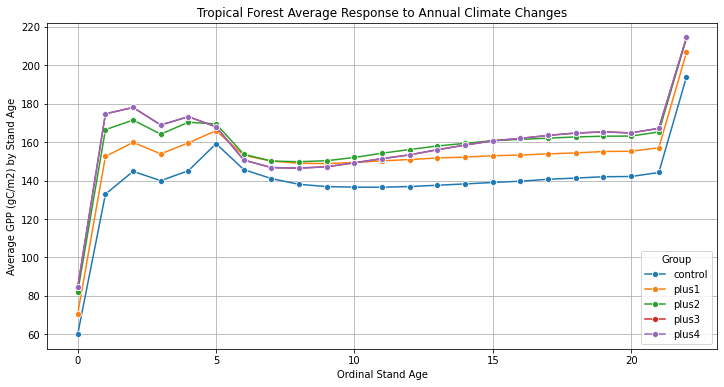

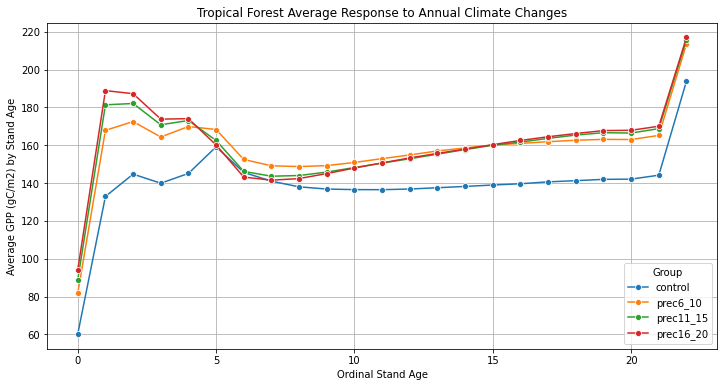

In [60]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=standage_avgs.loc[~standage_avgs['label'].str.contains('prec')], x='ordinal_stand_age', y=f'mean_{var}', hue='label', marker='o')
plt.title(f"{pft} Forest Average Response to Annual Climate Changes")
plt.xlabel("Ordinal Stand Age")
plt.ylabel(f"Average {var} (gC/m2) by Stand Age")
plt.legend(title='Group')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=standage_avgs.loc[~standage_avgs['label'].str.contains('plus')], x='ordinal_stand_age', y=f'mean_{var}', hue='label', marker='o')
plt.title(f"{pft} Forest Average Response to Annual Climate Changes")
plt.xlabel("Ordinal Stand Age")
plt.ylabel(f"Average {var} (gC/m2) by Stand Age")
plt.legend(title='Group')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=standage_avgs.loc[~standage_avgs['label'].str.contains('plus')], x='ordinal_stand_age', y=var, hue='label', marker='o')
plt.title(f"{pft} Forest Average Response to Annual Climate Changes")
plt.xlabel("Ordinal Stand Age")
plt.ylabel(f"Average {var} (gC/m2) by Stand Age")
plt.legend(title='Group')
plt.grid(True)
plt.show()

In [67]:
all_standage_avgs

,ordinal_stand_age,mean_GPP,label,var,mean_NPP,mean_VEGC,mean_SOILORGC
0,0,60.188641,control,GPP,NaN,NaN,NaN
1,1,132.928101,control,GPP,NaN,NaN,NaN
2,2,144.744736,control,GPP,NaN,NaN,NaN
3,3,139.931229,control,GPP,NaN,NaN,NaN
4,4,145.113708,control,GPP,NaN,NaN,NaN
...,...,...,...,...,...,...,...
179,18,NaN,prec16_20,SOILORGC,NaN,NaN,5166.310547
180,19,NaN,prec16_20,SOILORGC,NaN,NaN,5190.721680
181,20,NaN,prec16_20,SOILORGC,NaN,NaN,5191.449707
182,21,NaN,prec16_20,SOILORGC,NaN,NaN,5198.187012
